# YouTube Search Engine Analysis

**Abstract**
<!--Abstract-->
YouTube is the world's most popular online video sharing platform. According to YouTube, its number of monthly active user exceeded 2 billions in 2020, and its continuously increasing. Not only to users, also to business, using YouTube to marketise business becomes more important. Over 60% of business worldwide use YouTube for business purpose (Buffer, 2019). Therefore, it is important to look at how the YouTube algorithm works in order to set the most appropriate strategy to promote business using YouTube. YouTube algorithm mainly works in two ways: recommendation and search results. This notebook is specifically explore the ways in which search engine algorithm works.

**Table of Contents**
1. [Problem Statement](#ch1)
2. [Dataset Information](#ch2)
3. [Data Preprocessing](#ch3)
4. [Exploratory Data Analysis](#ch4)
5. [Modelling Data](#ch5)
6. [Hyperparameters Tuning](#ch6)
7. [Feature Selection](#ch7)
8. [Implementation and Conclusion](#ch8)

<a id="ch1"></a>
## 1. Problem Statement

*Do YouTube search results give you back the right result you want to find out?*
<!--prblem statement-->
When you search something on YouTube, it returns 'the most relevant' search results by default. However, I have experienced quite a few times that videos ranked high on search results are not necessarily relevant to the result I was searching for. The experience motivated me to explore YouTube search engine algorithm. Therefore, I will dig in how the search engine algorithm works, especially what factors affect rank of search results. Further, this project ultimately aims to create a better search algorithm.

<a id="ch2"></a>
## 2. Dataset Information

1) Methodology
- Use Chrome web driver and scrap data from YouTube web page.
- Set 5 keywords to search and collect top 10 results of each keyword for everyday from 18/01/2021 to 22/02/2021.
- Selected keywords are: mukbang, game, vlog, review and asmr. Keywords are selected based on popularity in Korea.
- All keywords are searched in Korean language (except ASMR), accordingly, results are localised (South Korea).

<!--var-->

2) Variables
- index: index
- category: 5 keywords
- url: video url
- rank: rank shown on search results (range 0~9)
- name: channel name
- subscribers: number of subscribers
- title: video title (localised)
- view_count: number of view
- like: number of like
- dislike: number of dislike
- comments: number of comment
- date: data created at
- hashtag: hashtag used in the video description
- search_date: date searched at
- time_sec: video duration converted in seconds

In [1]:
# import modules

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# connect to DB and read data

DB_HOST = 'localhost'
DB_NAME = 'youtubeDB'
DB_USER = 'postgres'
DB_PASS = ''
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST)

# write postgresql query to import data from DB
def sql_to_df(conn, select_query,columns):
    cursor=conn.cursor()
    cursor.execute(select_query)
    
    tupples=cursor.fetchall()
    cursor.close()
    
    df=pd.DataFrame(tupples, columns=columns)
    return df

columns=['index','category', 'url', 'rank', 'name', 'subscribers', 'title',
       'view_count', 'like', 'dislike', 'comments', 'date', 'hashtag',
       'search_date', 'time_sec']

df=sql_to_df(conn, "SELECT * FROM search_data",columns)
df.head(3)

,index,category,url,rank,name,subscribers,title,view_count,like,dislike,comments,date,hashtag,search_date,time_sec
0,0,먹방,https://www.youtube.com/watch?v=i0pBF2eITeE,0,히밥heebab,549000,조리법이 너무 간단해서 먹다보니.. 평생 먹을 새우를 이날 다 먹어버렸다...감바스...,148803,2877,97,315,2021-01-17,"['#쿠캣마켓', '#감바스', '#히밥', '#쿠캣', '#감바스', '#새우',...",2021-01-18,623
1,1,먹방,https://www.youtube.com/watch?v=xcM5dhFYaDc,1,EUNCHIKO은치코,109000,"먹방, 일상 브이로그 | 언니표 오므라이스, 지지고, 호식이 치킨, 낙곱새, 타트체...",87352,2228,41,0,2021-01-16,"['#먹방브이로그', '#일상브이로그', '#입짧은먹방']",2021-01-18,1109
2,2,먹방,https://www.youtube.com/watch?v=YABB9lrOoWk,2,사나이 김기훈,1650000,아내랑 삼겹살과 봄동비빔밥 먹방,566568,6964,154,561,2021-01-16,[],2021-01-18,458


In [3]:
# reducing memory (reference: Ferreira, https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# reduce data memory 
df= reduce_mem_usage(df)

Mem. usage decreased to  0.13 Mb (32.5% reduction)


<a id="ch3"></a>
## 3. Data Preprocessing

- 3.1 Correcting Data
- 3.2 Completing Data
- 3.3 Feature Engineering
- 3.4 Converting Data

### 3.1 Correcting
- Correcting datatype
- Drop duplicated data
- Correcting Missing Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        1690 non-null   int16 
 1   category     1690 non-null   object
 2   url          1690 non-null   object
 3   rank         1690 non-null   int8  
 4   name         1690 non-null   object
 5   subscribers  1690 non-null   int32 
 6   title        1690 non-null   object
 7   view_count   1690 non-null   int32 
 8   like         1690 non-null   int32 
 9   dislike      1690 non-null   int32 
 10  comments     1690 non-null   int32 
 11  date         1690 non-null   object
 12  hashtag      1690 non-null   object
 13  search_date  1690 non-null   object
 14  time_sec     1690 non-null   int16 
dtypes: int16(2), int32(5), int8(1), object(7)
memory usage: 133.8+ KB


**Drop duplicated data**
<!---note--->
Since the dataset is periodically obtained, some videos are repeatedly collected if it is appeared on a search result continuously. It could be interesting to explore further that how increases of views and user interaction over time affect search results. However, in this project, duplicated data might cause noise or bias. Therefor, I decide to drop duplicated data.

In [6]:
print("Number of duplicated data is:",df.url.duplicated().sum(), 
      "\n total %.0f %%" % (df.url.duplicated().sum()/len(df)*100),"of dataset")

Number of duplicated data is: 677 
 total 40 % of dataset


Total 40% of entire dataset seems quite a lot, however, I wrangled much more data than I have planned originally, due to significant percentage of duplicated data. Therefore, I will continue the analysis with the remain dataset.

In [7]:
# drop duplicated data based on 'url' and keep one that collected earlier.
df.drop_duplicates('url',keep='first',inplace=True)
df.drop('url',axis=1,inplace=True)

#### Correcting Datatype

- index: drop index, since it's duplicated.
- category: map category in English for better interpretation.
- date and search_date: change datatype from object to pd.datetime

In [8]:
# drop index
df=df.drop('index',axis=1)
df.date=pd.to_datetime(df.date)
df.search_date=pd.to_datetime(df.search_date)
category_to_eng = {'먹방':'mukbang', '게임':'game', '브이로그':'vlog', '리뷰':'review','ASMR':'asmr'}
df.category=df.category.map(category_to_eng)
df.reset_index(inplace=True)
# check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        1013 non-null   int64         
 1   category     1013 non-null   object        
 2   rank         1013 non-null   int8          
 3   name         1013 non-null   object        
 4   subscribers  1013 non-null   int32         
 5   title        1013 non-null   object        
 6   view_count   1013 non-null   int32         
 7   like         1013 non-null   int32         
 8   dislike      1013 non-null   int32         
 9   comments     1013 non-null   int32         
 10  date         1013 non-null   datetime64[ns]
 11  hashtag      1013 non-null   object        
 12  search_date  1013 non-null   datetime64[ns]
 13  time_sec     1013 non-null   int16         
dtypes: datetime64[ns](2), int16(1), int32(5), int64(1), int8(1), object(4)
memory usage: 78.3+ KB


- Columns: Total 14 columns consist of 5 qualitative, 8 quantitatiive and 2 datetime data.
- Rows: 1013 rows

#### Correcting missing data


Although the information shows there is no missing data in the dataset, there are a number of null values in this dataset . Currently,  missing data is recorded as '0'.
Columns containing missing data are 'subscribers', 'like', 'dislike', 'comments' and 'time_sec'.
- 1) number of subscribers can be hidden by a video creater.
- 2) number of likes and dislikes can be hidden by a video creater.
- 3) comments can be turned off by a video creater.
- 4) sometimes, the result failed to collecet number of comments, if there are advertisements in video description.
    - (haven't sorted it out why it's happening, but I will update once I figure it out!)
- 5) when a video was on live streaming during data collection, time_sec recorded as 0.

While gathering data, I encoded null values as 0 for easier data processing. Code I used for data gathering is available in here(click). I will re-encode these zeroes into 'NaN'.
<!---note--->
*Important Note*
- if both like and dislike are 0, it indicates the number of like/dislike is hidden. --> replace both as NaN
- if number of like is not zero but dislike is zero, it means the actual number of dislike is zero

In [9]:
# replace 0 as NaN -- subscribers, comments, time_sec
df[['subscribers','comments','time_sec']]=df[['subscribers','comments','time_sec']].replace(0,np.nan)

In [10]:
# replace number of dislike as NaN only if number of like is 0 

def dislike_fillna(cols):
    
    like=cols[0]
    dislike=cols[1]
    
    if like == 0 & dislike == 0:
        return np.nan
   
    else:
        
        return dislike

In [11]:
# dislike: replace 0 as NaN only if number of likes is 0 
df['dislike']=df[['like','dislike']].apply(dislike_fillna, axis=1)

In [12]:
# like: replace 0 as NaN
df['like']=df['like'].replace(0,np.nan)

In [13]:
# how much data is missing? in %
print(df.apply(lambda x: x.isna().sum()/len(x)*100))

index           0.000000
category        0.000000
rank            0.000000
name            0.000000
subscribers     5.133268
title           0.000000
view_count      0.000000
like            8.390918
dislike         8.390918
comments       25.567621
date            0.000000
hashtag         0.000000
search_date     0.000000
time_sec        2.270484
dtype: float64


After correcting zeroes as NaN,
- subscribers: 5% missing
- like& dislike: 8% missing
- comments: 25% missing
- time_sec: 2% missing

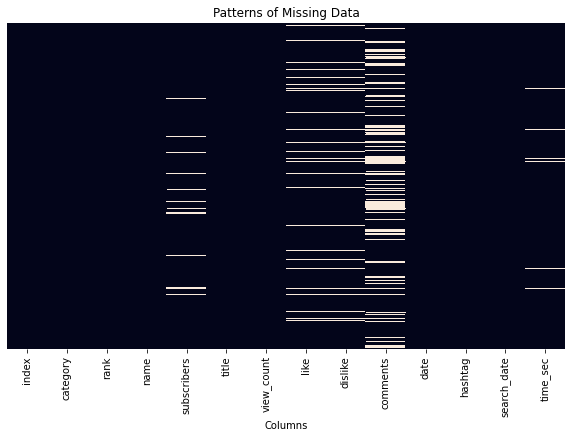

In [14]:
# Visualising 'missing data' in dataset
plt.figure(figsize=(10,6))
g=sns.heatmap(data=df.isna(), yticklabels=False,cbar=False)
__=g.set(title='Patterns of Missing Data', xlabel='Columns')

Types of missing data: MAR (Missing At Random)

<!---note--->

Heatmap above shows patterns of missing data. Although there are some degrees of randomness, randomness is related to each other to some extent.

### 3.2 Completing Data

If percentage of missing data is 10% or lower, it is often considered as acceptable in realistic term, as it has little influence on data. Around 25% of missing data is also considered as relistic percentage in real world data, however it should be imputed and evaluated carefully. I will employ three methodologies to impute missing data base on its amount.

<!---note--->

Data imputation methodology
- 1) basic approach: subscribers & time_sec - impute with median
- 2) advanced approach: like & dislike - impute with median grouped by category
- 3) complex approach: employ random forest regression to impute

**subscribers, time_sec** : median

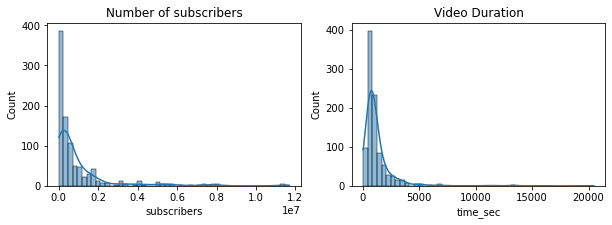

In [15]:
# histogram of subscribers 
plt.figure(figsize=(10,3))
plt.subplot(121)
sns.histplot(x='subscribers',data=df,bins=50,kde=True)
plt.title("Number of subscribers")
plt.subplot(122)
sns.histplot(x='time_sec',data=df,bins=50,kde=True)
__=plt.title("Video Duration")

subscriber and time_sec are highly positively skewed. Since only a small amount of data is missing (around 5%), a method to impute is less likely to impact on overall distribution. Therefore, I will use median to fill missing data.

In [16]:
# impute subscribers and time_sec with median
df.subscribers.fillna(df.subscribers.median(),inplace=True)
df.time_sec.fillna(df.time_sec.median(),inplace=True)

**like, dislike** : median by category

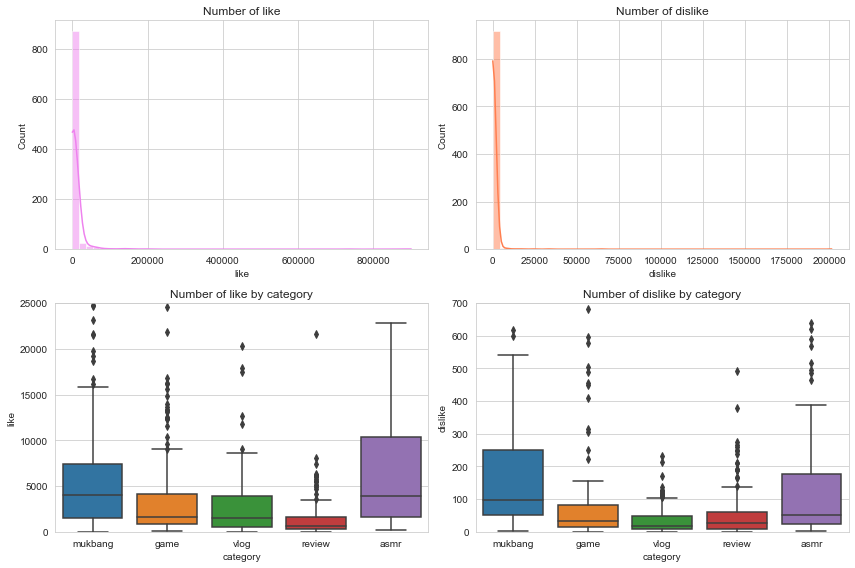

In [17]:
# like and dislike histogram 
plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
plt.subplot(221)
sns.histplot(df.like,bins=50,color='violet',kde=True)
plt.title('Number of like')

plt.subplot(222)
sns.histplot(df.dislike,bins=50,color='coral',kde=True)
plt.title('Number of dislike')

plt.subplot(223)
sns.boxplot(x=df.category, y=df.like)
plt.ylim(0,25000)
plt.title('Number of like by category')

plt.subplot(224)
sns.boxplot(x=df.category, y=df.dislike)
plt.ylim(0,700)
__=plt.title('Number of dislike by category')
plt.tight_layout()

As seen on histogram, both like and dislike are heavily skewed and concetrated around smaller values(like: <5000, dislike: <100). Thus it seems more appropriate to adopt median to fill missing data. Boxplots indicate the median value is varied depends on category. Therefore, I will use median grouped by category to impute missing data.

In [18]:
# median of like and dislike grouped by 5 categories(search keywords)
median_by_category=df.groupby('category',as_index=False)[['like','dislike']].median()
median_by_category

,category,like,dislike
0,asmr,3887.5,50.0
1,game,1645.0,32.5
2,mukbang,4069.0,96.0
3,review,688.0,26.0
4,vlog,1508.0,19.0


In [19]:
print("number of missing like and dislike data grouped by category")
print("-------------------------------------------------")
print(df[df.like.isna()]['category'].value_counts())

number of missing like and dislike data grouped by category
-------------------------------------------------
vlog       31
asmr       23
mukbang    22
review      6
game        3
Name: category, dtype: int64


It cannot be argued that the category is the only factor associated with number of like and dislike, however it is a convenient indicator to use.

In [20]:
# define function to fill null values with category based median

def fill_like(cols):
    '''fill missing data of like with median of each category'''
    like=cols[0]
    category=cols[1]
    
    if pd.isna(like):
        
        if category == 'asmr':
            return median_by_category.iloc[0,1]
        elif category == 'game':
            return median_by_category.iloc[1,1]
        elif category == 'review':
            return median_by_category.iloc[2,1]
        elif category == 'mukbang':
            return median_by_category.iloc[3,1]
        else: # vlog
            return median_by_category.iloc[4,1]
    else:
        return like
    
def fill_dislike(cols):
    '''fill missing data of dislike with median of each category'''
    dislike=cols[0]
    category=cols[1]
    
    if pd.isna(dislike):
                
        if category == 'asmr':
            return median_by_category.iloc[0,2]
        elif category == 'game':
            return median_by_category.iloc[1,2]
        elif category == 'review':
            return median_by_category.iloc[2,2]
        elif category == 'mukbang':
            return median_by_category.iloc[3,2]
        else: #vlog
            return median_by_category.iloc[4,2]
    else:
        return dislike
            
        

In [21]:
df['like_imputed']=df[['like','category']].apply(fill_like,axis=1)
df['dislike_imputed']=df[['dislike','category']].apply(fill_dislike,axis=1)

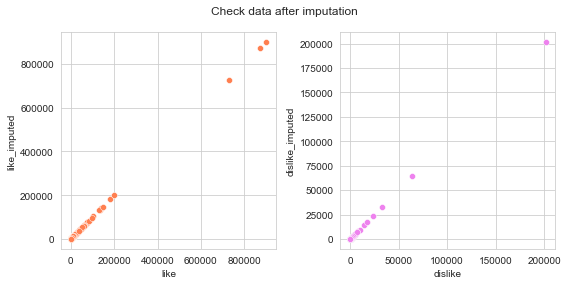

In [22]:
fig,(ax1,ax2)=plt.subplots(ncols=2, nrows=1,figsize=(8,4))
fig.suptitle("Check data after imputation")
sns.scatterplot(x=df['like'],y=df['like_imputed'],ax=ax1,color='coral')
sns.scatterplot(x=df['dislike'],y=df['dislike_imputed'],ax=ax2,color='violet')
_=plt.tight_layout()

Graphs above show that imputed data fits well.

**comments** : Random forest regression for statistical inference

In [23]:
# import modules
from sklearn.ensemble import RandomForestRegressor

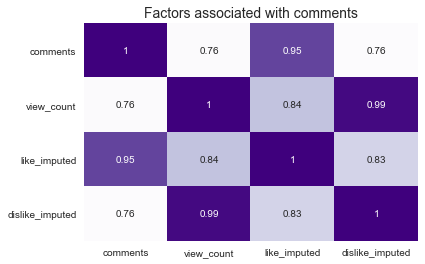

In [24]:
sns.heatmap(df[['comments','view_count','like_imputed','dislike_imputed']].corr(),annot=True,cmap='Purples',cbar=False)
_=plt.title('Factors associated with comments',fontsize=14)

'like_imputed' has the strongest correlation with 'comments'(.95). Other variables are also have strong correlation, however, if variables are strongly correlated to each other it degrades regression performance. Therefore, I will use 'like_imputed' as a indicator to fill missing 'comments' data.

In [25]:
# set new variable with numeric columns of the dataset to build a regression model
data = df[['comments','like_imputed']]
data.head()

,comments,like_imputed
0,315.0,2877.0
1,NaN,2228.0
2,561.0,6964.0
3,740.0,7578.0
4,280.0,145.0


In [26]:
# divide data elements into with and without comments
with_comments=data[data.comments.notnull()].values
without_comments=data[data.comments.isnull()].values

In [27]:
X, y = with_comments[:,1:], with_comments[:,0]

In [28]:
model = RandomForestRegressor(n_estimators=100,max_depth=2,
                               n_jobs=-1,random_state=0,oob_score=True)

In [29]:
# use model to fit and predict missing data
model.fit(X,y)

RandomForestRegressor(max_depth=2, n_jobs=-1, oob_score=True, random_state=0)

In [30]:
predicted_comments=model.predict(without_comments[:,1:]).astype(int)

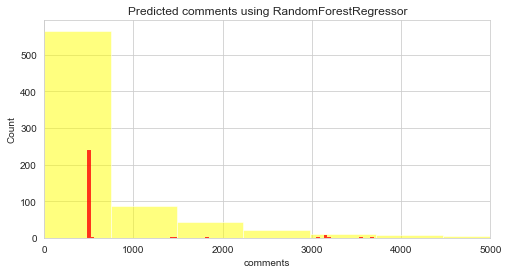

In [31]:
f,ax1=plt.subplots(figsize=(8,4))
g=sns.histplot(df['comments'],bins=80,color='yellow',alpha=.5)
sns.histplot(predicted_comments,bins=80,color='red',alpha=.8)
_=g.set(title='Predicted comments using RandomForestRegressor',xlim=(0,5000))

Yellow bars indicate the original 'comments' data, and red bars shows predicted missing values using random forest regressor. Although it seems concentrated around 500, the distribution looks fine so I will use this predicted value to fill missing data.

In [32]:
# insert predicted value into the original dataset
df.loc[(df.comments.isnull()),'comm_imputed']=predicted_comments

In [33]:
df.loc[(df.comm_imputed.isnull()),'comm_imputed']=y

In [34]:
# check discriptive table after fill all missing values 
# compare to original table at the beginning of section 2.2.2
df[['like_imputed','dislike_imputed','subscribers','time_sec','comm_imputed']].describe()

,like_imputed,dislike_imputed,subscribers,time_sec,comm_imputed
count,1013.000000,1013.000000,1.013000e+03,1013.000000,1013.000000
mean,8227.527641,548.331194,9.170607e+05,1309.981244,858.331688
std,47780.070630,6822.740409,1.635891e+06,1676.894791,2787.117305
min,2.000000,0.000000,1.390000e+02,59.000000,2.000000
25%,811.000000,17.000000,1.180000e+05,639.000000,207.000000
50%,1833.000000,38.000000,3.710000e+05,875.000000,484.000000
75%,4771.000000,95.000000,9.020000e+05,1323.000000,606.000000
max,900395.000000,201542.000000,1.170000e+07,20455.000000,59490.000000


In [35]:
# drop values with missing data
df.drop(['like','dislike','comments'],axis=1,inplace=True)

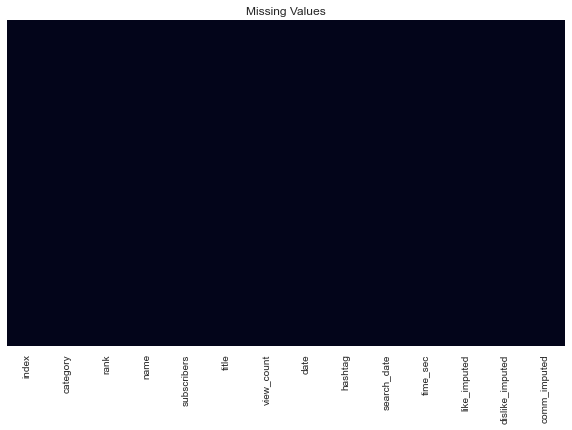

In [36]:
# check heatmap to see if there is any missing data left.
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), yticklabels=False,cbar=False)
__=plt.title("Missing Values")

### 3.3 Feature Engineering
create new columns
- target column: is_no3
- new feature columns
    - delta_days: delta days from the date uploaded video to the date result searched
    - in_3days: Boolean -whether the video is created within the last three days
    - views_by_subs: number of views divided by the number of subscriber of the channel
    - likes_ratio: measuring only positive reaction of viewers by controlling negative reaction
    - interactions: total number of reactions of viewers (like+dislike+comment)
    - number of hashtag: number of hashtag used in a video
    - tag_used: Boolean -whether a hashtag used in a video

**target column: is_no3**
<!--note-->
I set a target column as 'is_no3' that identifying whether a video is ranked at top 3 of each result page. Threshold of rank is 3. Because normally, top three videos can be seen directly on search page without scrolling down. Therefore, it has relatively more chances to be clicked or viewed. Also I assumed that Youtube search engine identifies top three videos are more relevant to user's query in comparison to rest of videos. Thus, in this project, I will finally use machine learning algorithms to predict whether a list of videos are ranked top three.

In [37]:
df['is_no3']=df.loc[:,'rank']<3

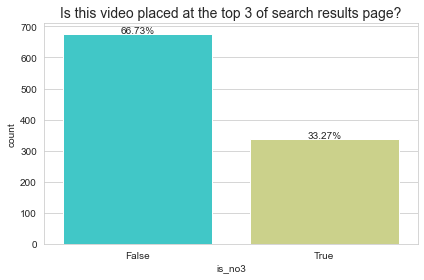

In [38]:
# see data distribution by barplot
g=sns.countplot(x=df.is_no3, palette='rainbow')
g.set_title("Is this video placed at the top 3 of search results page?", fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,height+3,
          '{:1.2f}%'.format(height/len(df)*100),
          ha="center")
plt.tight_layout()

Since I collected top ten results of each keyword, around 30% of dataset are ranked top three.

#### delta days & in_3days
- delta_days: calculate delta days from the date searched to date published (var: date, search_date)
- in_3days: binary variable whether the video is published within last three days (var: delta_days)

In [39]:
df['delta_days']=(df['search_date']-df['date']).dt.days

In [40]:
# we will use deltadays to calculate ratio, therefore add 1 to all values
df.delta_days=df.delta_days+1

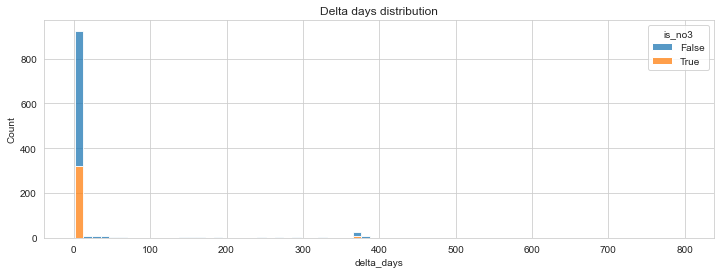

In [41]:
plt.figure(figsize=(12,4))
plt.title("Delta days distribution")
_=sns.histplot(x=df.delta_days,hue=df.is_no3,bins=70,multiple='stack')

Most of videos are relatively new -published within the last three days.

In [42]:
df['in_3days']=df.loc[:,'delta_days']<3

In [43]:
print("%.2f %% of data is created within last three days"%(len(df.loc[df['in_3days']==True])/len(df)*100))

76.80 % of data is created within last three days


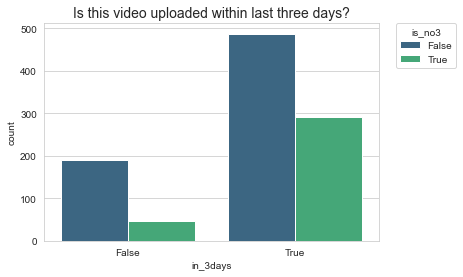

In [44]:
g=sns.countplot(x='in_3days',palette='viridis' , hue='is_no3', data=df)
g.set_title("Is this video uploaded within last three days?", fontsize=14)
_=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='is_no3')

It seems 'new videos' tend to get hyped. Probability of ranked top three seems much higher in new videos in comparison to old videos.

**view counts per subscribers ratio**
- views by subs: view count divided by number of subscribers

In [45]:
df['views_by_subs']=df['view_count']/df['subscribers']

**like per dislike ratio**
- likes ratio: like vs dislike ratio. number of likes - dislike / total reaction(like+dislike)

In [46]:
df['likes_ratio'] = (df.like_imputed-df.dislike_imputed)/(df.like_imputed+df.dislike_imputed)

**user interactions**
- like+dislike+comments

In [47]:
df['interactions']=(df.like_imputed+df.dislike_imputed+df.comm_imputed)

**number of hashtag and tag used**

In [48]:
# count number of hashtags used by counting "#"
df['num_of_tag']=df['hashtag'].apply(lambda x: x.count("#"))

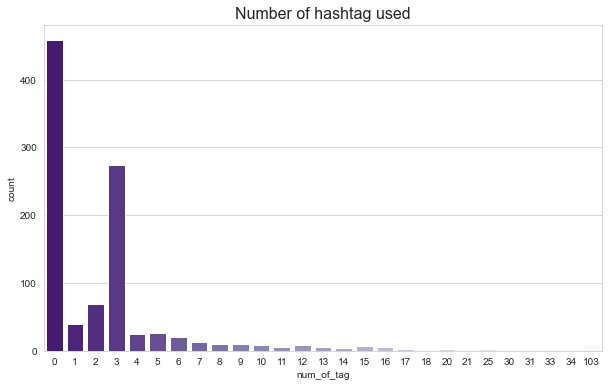

In [49]:
plt.figure(figsize=(10,6))
plt.title("Number of hashtag used", fontsize=16)
_=sns.countplot(x='num_of_tag',data=df,palette='Purples_r')

Almost half of dataset has no hashtag. Among videos with hashtags, most of videos used three or less hashtags.

In [50]:
df['tag_used']=df['num_of_tag'].apply(lambda x: True if x!=0 else False)

54.79 % of data has at least one hashtag


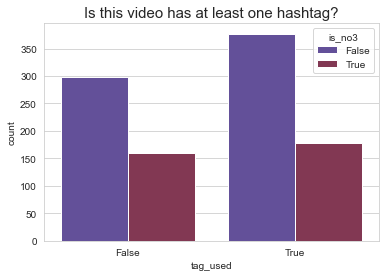

In [51]:
print("%.2f %% of data has at least one hashtag"%(len(df.loc[df['tag_used']==True])/len(df)*100))
plt.title("Is this video has at least one hashtag?", fontsize=15)
_=sns.countplot(x='tag_used',data=df,hue='is_no3',palette='twilight')

### 3.4 Converting Data

In [52]:
category=pd.get_dummies(df.category)

In [53]:
df=pd.concat([df,category],axis=1)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            1013 non-null   int64         
 1   category         1013 non-null   object        
 2   rank             1013 non-null   int8          
 3   name             1013 non-null   object        
 4   subscribers      1013 non-null   float64       
 5   title            1013 non-null   object        
 6   view_count       1013 non-null   int32         
 7   date             1013 non-null   datetime64[ns]
 8   hashtag          1013 non-null   object        
 9   search_date      1013 non-null   datetime64[ns]
 10  time_sec         1013 non-null   float64       
 11  like_imputed     1013 non-null   float64       
 12  dislike_imputed  1013 non-null   float64       
 13  comm_imputed     1013 non-null   float64       
 14  is_no3           1013 non-null   bool   

<a id="ch4"></a>
## 4. Exploratory Data Analysis

- 4.1 Explore Data by Category
- 4.2 Explore Data by Feature Columns
    - 4.2.1 Delta Days
    - 4.2.2 View Count
    - 4.2.3 User Interaction

**Response Column: is_no3**

**category**

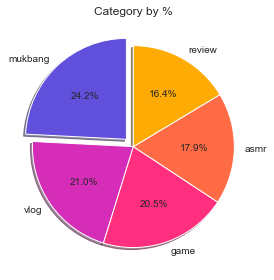

In [55]:
pie_data=df.category.value_counts()

labels = ['mukbang','vlog','game','asmr','review']
sizes = [pie_data[0],pie_data[1],pie_data[2],pie_data[3],pie_data[4]]
colors = ['#6050DC','#D52DB7','#FF2E7E','#FF6B45', '#FFAB05']
explode=(0.1,0,0,0,0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, shadow=True,explode=explode)
plt.title("Category by %")
plt.tight_layout()


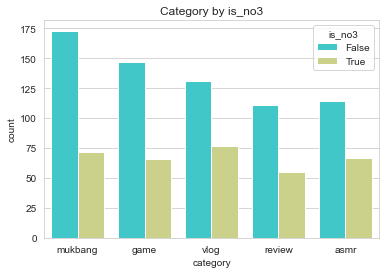

In [56]:
sns.countplot(x=df.category, hue=df.is_no3, palette='rainbow')
_=plt.title('Category by is_no3')

After drop duplicated data category 'mukbang' takes the largest percentage of data (24%) and review takes the smallest(16%). However, category seems almost equally distributed.

### 4.1 Explore Data by Category

In [57]:
# set display format
pd.set_option('display.float_format', '{:.2f}'.format)

In [58]:
# split data by category
mukbang=df.loc[(df['category']=='mukbang')]
game=df.loc[(df['category']=='game')]
vlog=df.loc[(df['category']=='vlog')]
review=df.loc[(df['category']=='review')]
asmr=df.loc[(df['category']=='asmr')]

In [59]:
# pivot table: mean value of each category
pd.pivot_table(df, index=['is_no3','category'],values=['like_imputed','dislike_imputed','comm_imputed','subscribers','view_count'],aggfunc='mean')

comm_imputed  dislike_imputed  like_imputed  subscribers  \
is_no3 category                                                             
False  asmr           2177.07          3395.48      37459.25   2058115.96   
       game            741.16            87.06       3092.67    579683.88   
       mukbang         951.11           450.64       6826.38   1430580.92   
       review          331.32            50.55       1574.92    271305.68   
       vlog            352.79            26.89       1826.14    176806.93   
True   asmr           1132.99           531.85      11026.86   1365795.82   
       game            999.61            69.74       4723.65    654428.33   
       mukbang         932.10           299.38       8384.94   1755051.39   
       review          313.27            61.53       1566.35    400799.27   
       vlog            501.22            42.95       3559.48    328160.39   

                 view_count  
is_no3 category              
False  asmr      2874377.30  
       game       176129.72  
       mukbang    288267.08  
       review      99474.19  
       vlog        57422.78  
True   asmr       539913.51  
       game       171748.06  
       mukbang    304269.00  
       review     110271.38  
       vlog       103390.69

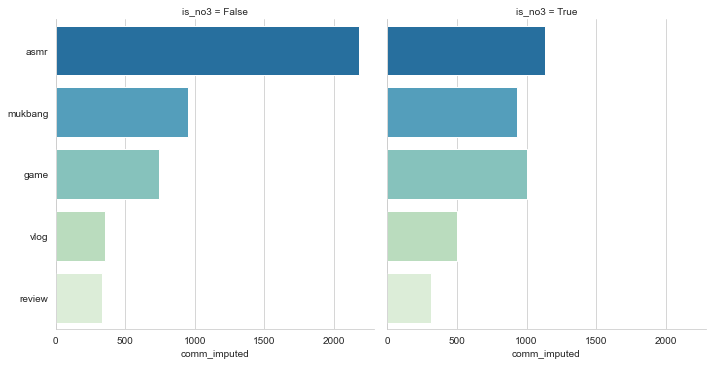

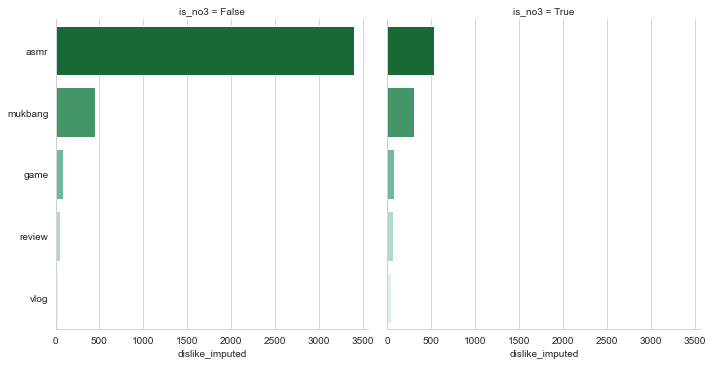

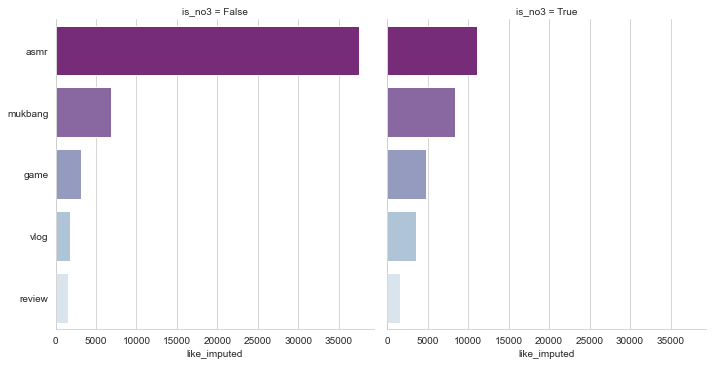

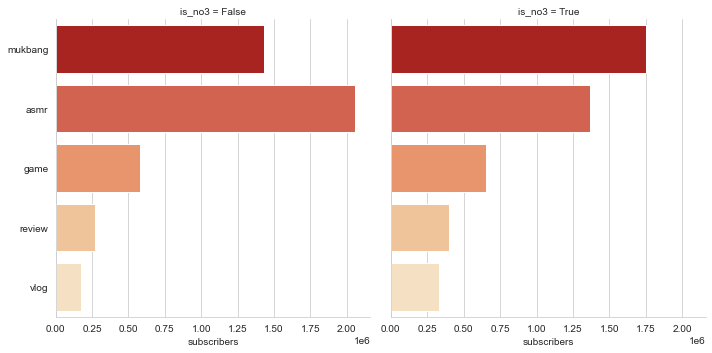

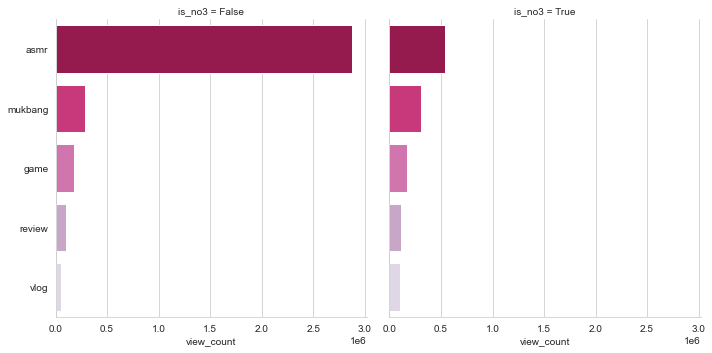

In [60]:
## See visualised chart

# like
plot_order = df.groupby('category')['comm_imputed'].sum().sort_values(ascending=False).index.values
g=sns.catplot(x='comm_imputed',y='category',col='is_no3',kind='bar',ci=None, data=df, order=plot_order,palette='GnBu_r')
g.set(ylabel='')
# dislike
plot_order = df.groupby('category')['dislike_imputed'].sum().sort_values(ascending=False).index.values
h=sns.catplot(x='dislike_imputed',y='category',col='is_no3',kind='bar',ci=None, data=df, order=plot_order,palette='BuGn_r')
h.set(ylabel='')
# comments
plot_order = df.groupby('category')['like_imputed'].sum().sort_values(ascending=False).index.values
i=sns.catplot(x='like_imputed',y='category',col='is_no3',kind='bar',ci=None, data=df, order=plot_order,palette='BuPu_r')
i.set(ylabel='')
# subscribers
plot_order = df.groupby('category')['subscribers'].sum().sort_values(ascending=False).index.values
j=sns.catplot(x='subscribers',y='category',col='is_no3',kind='bar',ci=None, data=df, order=plot_order,palette='OrRd_r')
j.set(ylabel='')
# view counts
plot_order = df.groupby('category')['view_count'].sum().sort_values(ascending=False).index.values
k=sns.catplot(x='view_count',y='category',col='is_no3',kind='bar',ci=None, data=df, order=plot_order,palette='PuRd_r')
_=k.set(ylabel='')

- comment: Number of comment is highest in 'asmr'. It seems number of comment is not a impactful value to decide rank. However, higher number of comment negatively affects ranking in 'asmr' category.
- dislike: General number of dislike seems negatively related to rank. Number of dislike is highest in 'asmr' across all categories.
- like: Along with number of comment, number of like does not have distinct relationship with rank.
- subscriber: High number of subscriber is positively related to rank to some extent, but not necessarily. Number of subscribers tends to higher in asmr and mukbang.
- view count: Higher number of views does not have meaningful impact on rank. 'asmr' seems the most popular category with highest number of views, subscribers and so on.

### 4.2 Explore Data by Feature Columns

### 4.2.1 The impact of 'delta days' on other factors

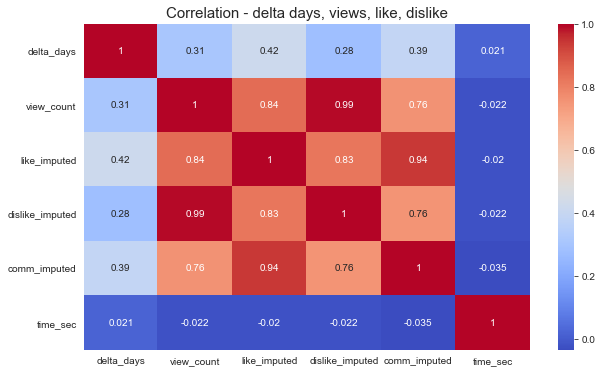

In [61]:
plt.figure(figsize=(10,6))
g=sns.heatmap(df[['delta_days','view_count','like_imputed','dislike_imputed','comm_imputed','time_sec']].corr(method='pearson'),annot=True,cmap='coolwarm')
_=g.set_title('Correlation - delta days, views, like, dislike', fontsize=15)

*Pearson's correlation matrix*
<!--note-->
It shows very strong correlation between number of likes(.84), dislikes(.99), comments(.76) and view counts. It indicates viewers tend to engage with the video by either clicking like or dislike or comments. However, delta days has weak correlation with other variables (.02~.42). Despite some extent of influence of delta days to other variables (e.g. videos with larger delta days tend to have higher view counts etc), in this analysis, by adopting Pearson's correlation coefficients, I will ignore the impact of delta days.

### 4.2.2 View count

**view count and views by subs**

- view count: view counts of each video
- views by subs: views/subs
    - if views_by_subs > 1.0, indicates view counts exceeded the number of subscribers of the channel

**top20 most viewed**

In [62]:
# top20 most viewed
view_top20=df.sort_values(by='view_count',ascending=False)[['category','is_no3','view_count','subscribers','views_by_subs']].head(20)
# top20 highest views by subscribers
views_by_subs_top20=df.sort_values(by='views_by_subs',ascending=False)[['category','is_no3','view_count','subscribers','views_by_subs']].head(20)

In [63]:
# present pivot table of top20 most viewed videos by category
pd.pivot_table(view_top20,index=['is_no3','category'],
               values=['view_count','subscribers','views_by_subs'],aggfunc=['mean','count']).iloc[:,:-2]

mean                                 count
                subscribers  view_count views_by_subs subscribers
is_no3 category                                                  
False  asmr      7914538.46 23930033.54          3.33          13
       game      2130000.00  4843752.00          2.27           1
       mukbang   4040000.00  4875878.00          1.12           2
True   asmr      5241000.00  9786074.67          5.47           3
       game       174000.00  2707103.00         15.56           1

*top20 most viewed videos*
<!--text-->
ASMR tends to have higher view counts than other categories. However, the number of subscribers and view counts are higher in lower ranks. None of vlog and review videos are ranked in top 20 most viewed videos.

**top20 highest view by subs ratio**

In [64]:
# see top20 high view by subscribers ratio videos
pd.pivot_table(views_by_subs_top20,index=['is_no3','category'],
               values=['view_count','subscribers','views_by_subs'],aggfunc=['mean','count']).iloc[:,:-2]

mean                                  count
                subscribers   view_count views_by_subs subscribers
is_no3 category                                                   
False  asmr      7830000.00 151759553.00         19.38           1
       game         2473.33    138012.33         57.45           3
       mukbang    125000.00   1016546.50          8.24           2
       review      39525.71    478537.86         13.25           7
       vlog        28900.00    172272.00          5.96           1
True   asmr       433000.00   5775152.00         13.34           1
       game        89155.00   1373111.00         12.32           2
       review      17400.00    683276.00         39.27           1
       vlog         2930.00     24680.50         10.69           2

*top20 highest views by subs ratio*
<!--text-->
Game and review tend to have higher views by subs ratio. Views by subs ratio does not necessarily affect search results rank.

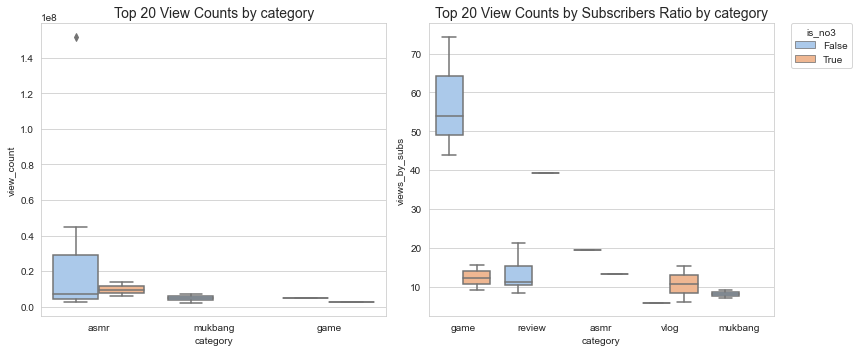

In [65]:
# visualising

f,((ax1,ax2))=plt.subplots(ncols=2,nrows=1,figsize=(12,5))

ax1=sns.boxplot(ax=ax1,x='category',y='view_count',hue='is_no3',data=view_top20,palette='pastel')
ax1.legend_.remove()
ax1.set_title('Top 20 View Counts by category',fontsize=14)
ax2=sns.boxplot(ax=ax2,x='category',y='views_by_subs',hue='is_no3',data=views_by_subs_top20,palette='pastel')
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='is_no3')
ax2.set_title('Top 20 View Counts by Subscribers Ratio by category',fontsize=14)
plt.tight_layout()

ASMR is the most popular category. Most of top 20 videos are ASMR and then mukbang and game. However, a lot of videos with higher view counts failed to rank top3. By looking at views subs ratio, game has highest views by subs ratio, review takes the second. However, absolute number of view counts is not very high, in opposition to ASMR. Even though views by subs ratio is highest in game, most of game videos are not in top3.

### 4.2.3 User Interaction 
- like
- dislike
- comments

**top20 most liked**

In [66]:
# top 20 most liked videos
like_top20=df.sort_values(by='like_imputed',ascending=False)[['category','is_no3','view_count',
                                                   'like_imputed','comm_imputed','likes_ratio']].head(20)

In [67]:
pd.pivot_table(like_top20,index=['is_no3','category'],
               values=['view_count','like_imputed','comm_imputed','likes_ratio'],aggfunc=['mean','count']).iloc[:,:-2]

mean                                       \
                comm_imputed like_imputed likes_ratio  view_count   
is_no3 category                                                     
False  asmr         13571.62    276128.23        0.87 23710378.23   
       mukbang       5598.00     67206.00        0.92  3402147.00   
True   asmr          8604.00    126538.67        0.85  9786074.67   

                       count               
                comm_imputed like_imputed  
is_no3 category                            
False  asmr               13           13  
       mukbang             4            4  
True   asmr                3            3

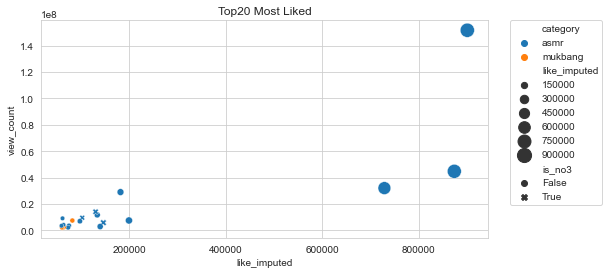

In [68]:
plt.figure(figsize=(8,4))
g=sns.scatterplot(x='like_imputed',y='view_count',hue='category',style='is_no3',sizes=(20,200),size='like_imputed',data=like_top20)
g.set_title('Top20 Most Liked')
_=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*top20 most liked videos*
<!--text-->
ASMR and mukbang are the most liked categories. However, higher number of like does not guarantee higher rank.

**top20 highest likes ratio**

In [69]:
likes_ratio_top20=df.sort_values(by='likes_ratio',ascending=False)[['category','is_no3','view_count',
                                                   'like_imputed','dislike_imputed','likes_ratio']].head(20)
pd.pivot_table(likes_ratio_top20,index=['is_no3','category'],
               values=['view_count','like_imputed','dislike_imputed','likes_ratio'],aggfunc=['mean','count']).iloc[:,:-2]

mean                                      \
                dislike_imputed like_imputed likes_ratio view_count   
is_no3 category                                                       
False  asmr                5.00      2553.00        1.00   16569.00   
       game                1.14       610.00        1.00   10289.00   
       review              6.50      3740.50        1.00   27351.00   
       vlog                2.71      1797.00        1.00   24379.86   
True   asmr               66.00     50149.00        1.00  155090.00   
       vlog               14.00      8741.50        1.00   76677.00   

                          count               
                dislike_imputed like_imputed  
is_no3 category                               
False  asmr                   1            1  
       game                   7            7  
       review                 2            2  
       vlog                   7            7  
True   asmr                   1            1  
       vlog                   2            2

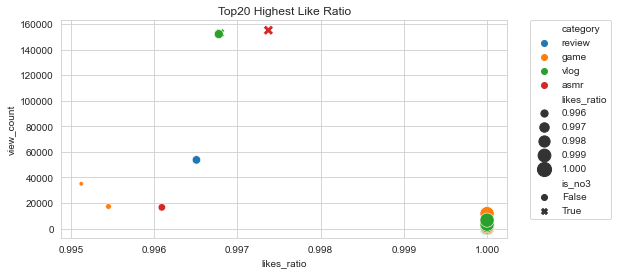

In [70]:
plt.figure(figsize=(8,4))
g=sns.scatterplot(x='likes_ratio',y='view_count',hue='category',style='is_no3',sizes=(20,200),size='likes_ratio',data=likes_ratio_top20)
g.set_title('Top20 Highest Like Ratio')
_=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*top 20 highest like ratio*
<!--text-->
Using likes ratio to evaluate quality of video or rank is not a appropriate measure. Videos with low view counts, low number of likes are accordingly more likely to have low dislikes, therefore record high in likes ratio. Most of videos with high like ratio and low view counts are failed to be ranked top three. In 'top20 most liked' result, minimum view count was 150000. Therefore, I will set view count 150000 as a threshold for measuring top20 highest like ratio result.

In [71]:
view_threshold=150000

In [72]:
likes_ratio_top20_v2=df.loc[df['view_count']>view_threshold].sort_values(by='likes_ratio',ascending=False)[['category','is_no3','view_count',
                                                   'like_imputed','dislike_imputed','likes_ratio']].head(20)

In [73]:
pd.pivot_table(likes_ratio_top20_v2,index=['is_no3','category'], 
              values=['view_count','like_imputed','dislike_imputed','likes_ratio'],aggfunc=['mean','count']).iloc[:,:-2]

mean                                      \
                dislike_imputed like_imputed likes_ratio view_count   
is_no3 category                                                       
False  game               52.40      9406.00        0.99  214487.80   
       vlog               58.33     11994.67        0.99  264041.00   
True   asmr               56.40     16856.60        0.99  198318.20   
       game               77.00     15926.25        0.99  216483.75   
       vlog               62.00     16003.33        0.99  316248.00   

                          count               
                dislike_imputed like_imputed  
is_no3 category                               
False  game                   5            5  
       vlog                   3            3  
True   asmr                   5            5  
       game                   4            4  
       vlog                   3            3

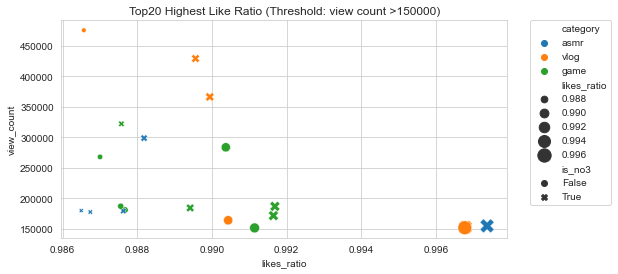

In [74]:
plt.figure(figsize=(8,4))
g=sns.scatterplot(x='likes_ratio',y='view_count',hue='category',style='is_no3',sizes=(20,200), size='likes_ratio',data=likes_ratio_top20_v2)
g.set_title('Top20 Highest Like Ratio (Threshold: view count >150000)')
_=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

After set threshold, a number of videos with high likes ratio with reasonably high view counts ranked top three.

**top20 most interacted**

In [75]:
interaction_top20=df.sort_values(by='interactions',ascending=False)[['category','is_no3','view_count','interactions']].head(20)

In [76]:
pd.pivot_table(interaction_top20, index=['is_no3','category'],
              values=['view_count','interactions'],aggfunc=['mean','count']).iloc[:,:-2]

mean            
                interactions  view_count
is_no3 category                         
False  asmr        317785.62 23710378.23
       mukbang      75673.00  3402147.00
True   asmr        145137.33  9786074.67

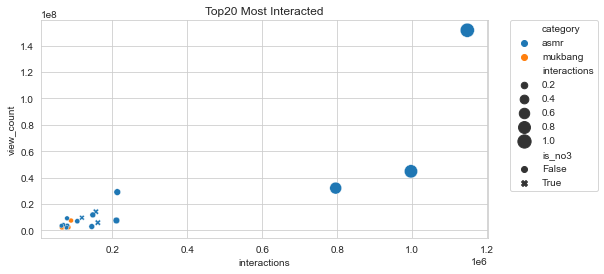

In [77]:
plt.figure(figsize=(8,4))
g=sns.scatterplot(x='interactions',y='view_count',hue='category',style='is_no3',sizes=(20,200), size='interactions',data=interaction_top20)
g.set_title('Top20 Most Interacted')
_=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*top20 most interacted*
<!--text-->
Only asmr and mukbang are ranked top20 in most interacted videos. Overall, asmr is the most popular category, therefore it has more view counts, likes, dislikes and comments. However, higher interaction does not affect rank of a video that much.

**Pearson's Correlation Matrix**

In [78]:
all_columns=['subscribers','view_count','like_imputed','dislike_imputed', 'comm_imputed','time_sec',
          'in_3days','delta_days','views_by_subs', 'likes_ratio', 'interactions',
          'num_of_tag','tag_used']

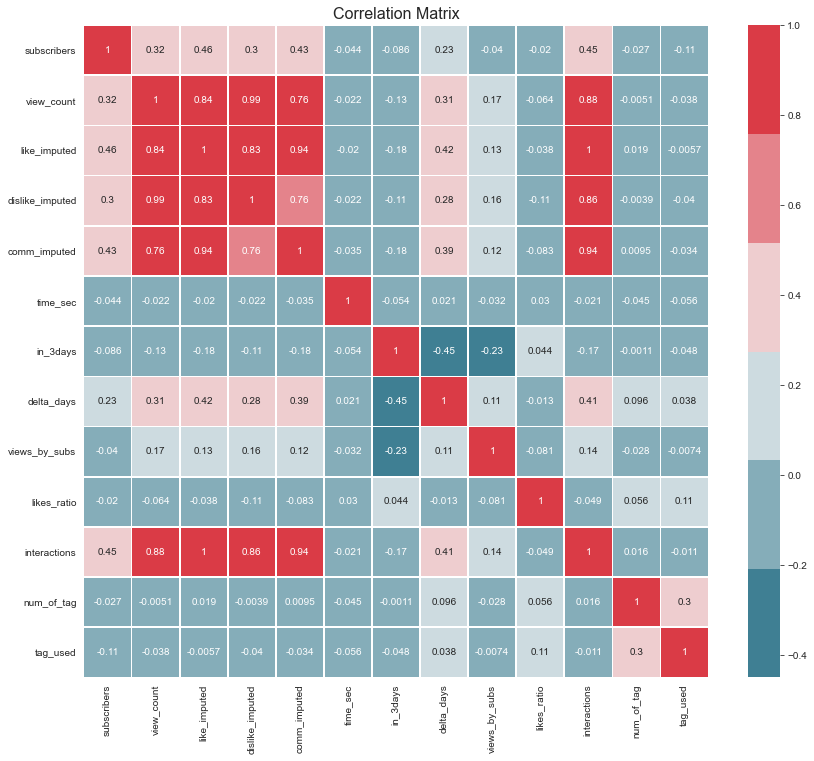

In [79]:
plt.figure(figsize=(14,12))
g=sns.heatmap(df[all_columns].corr(), cmap=sns.diverging_palette(220, 10),linewidth=.7,annot=True)
_=g.set_title("Correlation Matrix", fontsize=16)

Above graph is pearson's correlation matrix of all numeric variables. Variables have correlation (above .3) coloured red and variables with no correlation coloured blue. According to correlation analysis, variables such as view count, number of like, dislike, comments have a quite strong correlation. In some machine learning algorithm, highly correlated variables could result *Multicollinearity*. Therefore, feature selection should be carefully considered

<a id="ch5"></a>
## 5. Modelling Data
- 5.1 Split Dataset
- 5.2 Model Preparation
- 5.3 Machine Learning Pipeline 
- 5.4 Model Evaluation

### 5.1 Split Train, Validation and Test Data

In [80]:
# import modules
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, GridSearchCV
from tqdm import tqdm_notebook

In [81]:
# set feature columns to use
features=['subscribers','view_count','time_sec','like_imputed','dislike_imputed', 'comm_imputed',
          'in_3days','delta_days','views_by_subs', 'likes_ratio', 'interactions',
          'num_of_tag','tag_used','asmr', 'game', 'mukbang', 'review', 'vlog']

In [82]:
# X=feature column, y=target column
X = df[features]
y = df['is_no3']

In [83]:
# split trainvalid / test dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, test_size = 0.2, random_state=2)

# split train / valid dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=2)

# check shape
print("Train data size:{}, \nValidation data size:{}, \nTest data size:{}".format(X_train.shape, X_valid.shape, X_test.shape))

Train data size:(648, 18), 
Validation data size:(162, 18), 
Test data size:(203, 18)


### 5.2 Model Preparation
- Robust Scaler: I will use Robust Scaler to scale dataset before applying machine learning algorithms. Scaling is necessary in this dataset because most of numeric data is heavily skewed, and there are quite a few outliers. Robust scaler is less sensitive to outliers in comparison to other scalers such as standard scaler.
- Machine Learning Algorithms: Classification modles -SVM, Logistic Regression, Decision Tree, KNN, Gaussian Naive Bayes, Ensemble modles - Random Forest, AdaBoost, Gradient Boost, Extra Tree.

In [84]:
# set default random state
random_state=2
# scaler
scaler = RobustScaler()
# svm rbf
svm_rbf = svm.SVC(kernel = 'rbf', gamma = 0.1, C=1,random_state=random_state)
# logistic regression
log_reg = LogisticRegression(random_state=random_state)
# decision tree
tree = DecisionTreeClassifier(random_state=random_state)
# KNN
knn = KNeighborsClassifier()
# Gaussian Naive Bayes
gauss_nb = GaussianNB()
# random forest
rf = RandomForestClassifier(n_estimators=10)
# AdaBoost
abc= AdaBoostClassifier(random_state=random_state,learning_rate=0.1)
# Extra Tree
ex_tree=ExtraTreesClassifier(random_state=random_state)
# Gradient Boosting
grad_boost=GradientBoostingClassifier(random_state=random_state)
# kfold
kfold = KFold(n_splits=10, random_state=random_state)

#### Decide number of neighbors before running KNN Classifier

In [85]:
def get_num_of_neighbors(model):
    
    '''get most efficient number of neighbors in range(1,11)'''
    n= pd.Series()
    n_index=[1,5,10,15,20]
    
    for i in n_index:
        knn_model = KNeighborsClassifier(n_neighbors=i)
        knn_pipeline = Pipeline(steps=[('scaler', scaler),('model', knn_model)])
        knn_pipeline.fit(X_train,y_train)
        knn_pred = knn_pipeline.predict(X_valid)
        n=n.append(pd.Series(accuracy_score(y_valid, knn_pred)))
        
    '''plot to see result'''
    plt.figure(figsize=(8,4))
    plt.plot(n_index,n,linewidth=2,marker='o',mec='red',ms=15)
    plt.xticks(n_index)
    plt.title("Best Number of Neighbors",fontsize=14)
    
    return 'Best Score: %.2f' %n.values.max()

'Best Score: 0.70'

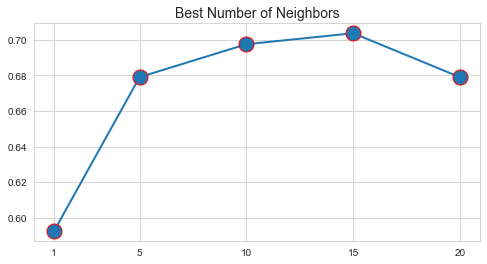

In [86]:
get_num_of_neighbors(knn)

Accuracy score is highest with n_neighbors=15, with value of 0.70

In [87]:
# Set number of neighbors for KNN
knn = KNeighborsClassifier(n_neighbors=15)

### 5.3 Set Pipeline to Perform and Evaluate Models
- Pipeline Process: Scaling(Robust Scaler) - Prediction(Train/valid) - Measure accuracy and AUC score - Evaluation(Cross Validation)

In [88]:
models = [svm_rbf, log_reg, tree, knn, gauss_nb, rf, abc, ex_tree, grad_boost]
model_result={'Parameters':[],'Accuracy Score':[],'CV Mean':[], 'CV Std':[], 'AUC Score':[]}
model_name = ['SVM', 'Logistic Regression', 'Decision Tree', 'KNearestNeighbor', 'GaussianNB', 'RandomForest',
             'AdaBoost', 'ExtraTree', 'GradientBoost']

In [89]:
cv_accuracy = []
cv_pred=[]

for model in tqdm_notebook(models):
    
    pipeline=Pipeline(steps=[('scaler', scaler), ('model', model)])
    pipeline.fit(X_train, y_train)
    prediction=pipeline.predict(X_valid)
    ac = accuracy_score(y_valid, prediction)
    auc_score=roc_auc_score(y_valid, prediction)
    
    model_result['Parameters'].append(model)
    model_result['Accuracy Score'].append(ac)
    model_result['AUC Score'].append(auc_score)

    
    cv_results=cross_val_score(model, X_train,y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    cv_accuracy.append(cv_results)
    
    model_result['CV Mean'].append(cv_results.mean())
    model_result['CV Std'].append(cv_results.std())
    
    y_pred = cross_val_predict(model, X_valid,y_valid, cv=kfold)
    cv_pred.append(y_pred)
    
model_evaluation=pd.DataFrame(model_result, index=model_name)
model_evaluation

,Parameters,Accuracy Score,CV Mean,CV Std,AUC Score
SVM,"SVC(C=1, gamma=0.1, random_state=2)",0.69,0.66,0.07,0.55
Logistic Regression,LogisticRegression(random_state=2),0.68,0.65,0.07,0.52
Decision Tree,DecisionTreeClassifier(random_state=2),0.69,0.62,0.05,0.67
KNearestNeighbor,KNeighborsClassifier(n_neighbors=15),0.70,0.65,0.07,0.61
GaussianNB,GaussianNB(),0.38,0.38,0.07,0.50
RandomForest,"(DecisionTreeClassifier(max_features='auto', r...",0.70,0.67,0.05,0.62
AdaBoost,"(DecisionTreeClassifier(max_depth=1, random_st...",0.67,0.66,0.06,0.50
ExtraTree,"(ExtraTreeClassifier(random_state=1872583848),...",0.70,0.68,0.07,0.63
GradientBoost,([DecisionTreeRegressor(criterion='friedman_ms...,0.70,0.67,0.07,0.62


### 5.4 Model Evaluation

#### Cross Validation Scores and Mean Accuracy

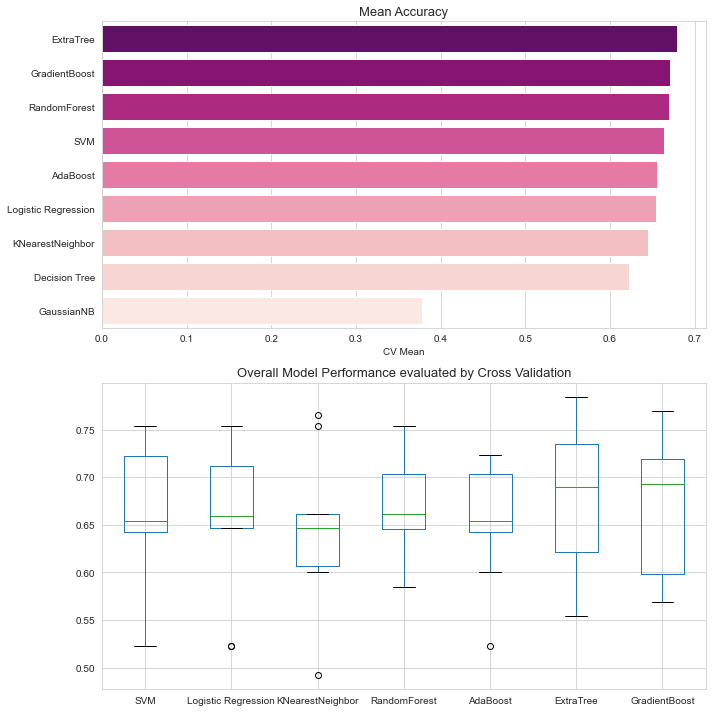

In [90]:
# Visualising model performance

model_evaluation.sort_values(by='CV Mean',ascending=False,inplace=True)
cv_index=model_evaluation.index
cv_accuracy_scores=pd.DataFrame(cv_accuracy, index=model_name)
cv_accuracy_scores.drop(['GaussianNB','Decision Tree'],inplace=True) # Remove low scored models -GaussianNB & DecisionTree- for better visualisation 

f,((ax1,ax2)) = plt.subplots(2,1, figsize=(10,10))
g=sns.barplot(ax=ax1,x=model_evaluation['CV Mean'],y=cv_index,palette='RdPu_r')
g.set_title("Mean Accuracy", fontsize=13)
h=cv_accuracy_scores.T.boxplot(ax=ax2)
h.set_title("Overall Model Performance evaluated by Cross Validation", fontsize=13)
plt.tight_layout()

#### Confusion Matrix

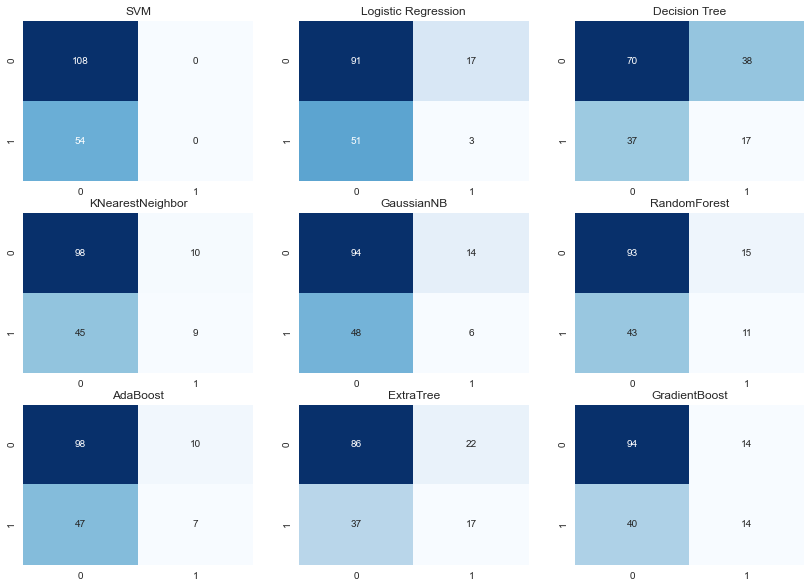

In [91]:
f, axs = plt.subplots(3,3, figsize=(14,10))
axs=axs.ravel()

for i in range(len(cv_pred)):
        sns.heatmap(confusion_matrix(y_valid, cv_pred[i]),ax=axs[i],annot=True,fmt='g',cmap="Blues",cbar=False)
        axs[i].set_title(model_name[i])

- Best model: Random Forest, Extra Tree, Gradient Boost

<!--text-->

The overall performance seems not very good with quite low AUC scores across models and low cross validation scores. There could be many reasons associated with model performance. For example, 1) Feature selection were not preceded thus, it affects models sensitive to multicolliniarity such as logistic regression. 2) The dataset does not contain enough information to predict search result rank. For example, users' click, watch time and watch history are also significant factor of search engine algorithm. However, the purpose of this proejct is using visible factors to predict rank. Therefore, I will continue the analysis with three best models noted above and improve model performance through hyperparameter tuning and feature selection.


<a id="ch6"></a>
## 6. Hyperparameters Tuning

In [92]:
# feature scaling
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [93]:
# Set parameters
# RandomForest
rf_param={
    'n_estimators':[100,200,300],
   'min_samples_split':[1,10,30],
    'min_samples_leaf':[1,10,30],
    'max_features':[1,5,10]
}


# Extra Tree
tree_param={
    'n_estimators':[100,200,300],
   'min_samples_split':[1,10,30],
    'min_samples_leaf':[1,5,10],
    'max_features':[1,5,10]
}



# GradientBoost
gb_param={
    'n_estimators' : [100,200,300],
    'max_depth': [2,4, 8],
    'learning_rate': [0.1, 0.05, 0.01],
    'min_samples_leaf': [50,100,150],
    'max_features': [0.3, 0.1,1,3] 
}


In [94]:
params=[rf_param, tree_param, gb_param]
grid_models = [rf, ex_tree, grad_boost]
grid_name=['RandomForest','ExtraTree','GradientBoost']

In [95]:
# GridSearch to find best parameter
grid_result={'Model':[],'Estimator':[],'Score':[]}
for i in tqdm_notebook(range(0,3)):
    
    result=GridSearchCV(grid_models[i], param_grid=params[i], cv=kfold, scoring='accuracy', n_jobs=-1)
    result.fit(X_trainval, y_trainval)
    best_est= result.best_estimator_
    best_score= result.best_score_
    
    grid_result['Model'].append(grid_name[i])
    grid_result['Estimator'].append(best_est)
    grid_result['Score'].append(best_score)
    

grid_result=pd.DataFrame(grid_result)
grid_result

,Model,Estimator,Score
0,RandomForest,"(DecisionTreeClassifier(max_features=5, min_sa...",0.72
1,ExtraTree,"(ExtraTreeClassifier(max_features=1, min_sampl...",0.71
2,GradientBoost,([DecisionTreeRegressor(criterion='friedman_ms...,0.70


In [96]:
# Apply best parameter of each model and evaluate performance with Cross Validation
best_scores={'Model':[],'Test Score':[]}
best_predictions=[]

for i in tqdm_notebook(range(len(grid_result))):
    
    cv_score=cross_val_score(grid_result.iloc[i,1], X_test, y_test, cv=kfold)
    cv_pred=cross_val_predict(grid_result.iloc[i,1], X_test, y_test, cv=kfold)
    best_predictions.append(cv_pred)
    
    best_scores['Model'].append(grid_result.iloc[i,0])
    best_scores['Test Score'].append(cv_score.mean())
    
pd.DataFrame(best_scores)


,Model,Test Score
0,RandomForest,0.70
1,ExtraTree,0.72
2,GradientBoost,0.64


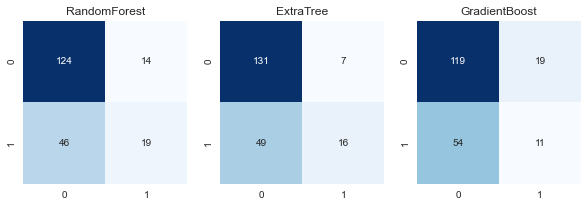

In [97]:
# Confusion Matrix of each model after applying hyperparameters tuning
f, axs = plt.subplots(1,3, figsize=(10,3))
axs=axs.ravel()

for i in range(0,3):
        sns.heatmap(confusion_matrix(y_test, best_predictions[i]),ax=axs[i],annot=True,fmt='g',cmap="Blues",cbar=False)
        axs[i].set_title(grid_result.iloc[i,0])

As seen on result above, GridSearch improved performance of each model. ExtraTree's model performance is higher than other two.

<a id="ch7"></a>
# 7. Feature Selection

In [98]:
feat_imp=[]
for i in range(len(grid_result)):
    model = grid_result.iloc[i,1]
    model.fit(X_train, y_train)
    fi=model.feature_importances_
    feat_imp.append(fi)

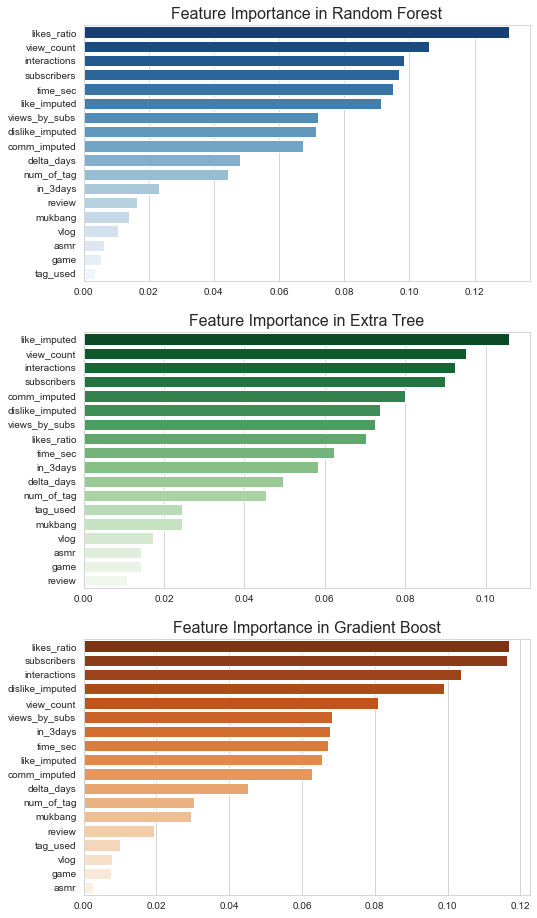

In [99]:
f, axes = plt.subplots(3,1,figsize=(8,16))
sns.barplot(x=pd.Series(feat_imp[0],features).sort_values(ascending=False),
            y=pd.Series(feat_imp[0],features).sort_values(ascending=False).index,
           palette='Blues_r',ax=axes[0])
axes[0].set_title("Feature Importance in Random Forest", fontsize=16 )

sns.barplot(x=pd.Series(feat_imp[1],features).sort_values(ascending=False),
            y=pd.Series(feat_imp[1],features).sort_values(ascending=False).index,
           palette='Greens_r',ax=axes[1])
axes[1].set_title("Feature Importance in Extra Tree", fontsize=16 )

sns.barplot(x=pd.Series(feat_imp[2],features).sort_values(ascending=False),
            y=pd.Series(feat_imp[2],features).sort_values(ascending=False).index,
           palette='Oranges_r',ax=axes[2])
_=axes[2].set_title("Feature Importance in Gradient Boost", fontsize=16 )

In [100]:
features_df=pd.DataFrame({'Features':features,
              grid_result.iloc[0,0]:feat_imp[0],
              grid_result.iloc[1,0]:feat_imp[1],
             grid_result.iloc[2,0]:feat_imp[2]})
features_df['Mean']=features_df.mean(axis=1)
features_df.sort_values(by='Mean',ascending=False,inplace=True)

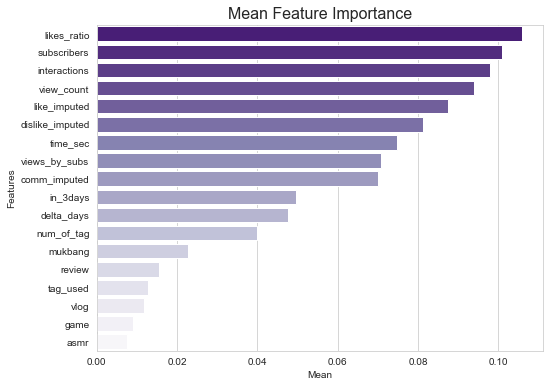

In [101]:
plt.figure(figsize=(8,6))
g=sns.barplot(x='Mean',y='Features',data=features_df,palette='Purples_r')
_=g.set_title("Mean Feature Importance", fontsize=16)

It seems likes_ratio, subscribers, view_count, interactions, like_imputed, dislike_imputed all fairly important in model performance. 

<a id="ch8"></a>
## 8. Implementation and Conclusion

### Implementation: ExtraTree Classification

In [102]:
features2 = ['subscribers','view_count','in_3days',
             'interactions','num_of_tag',
            'asmr','mukbang','review','vlog']

Features are selected based on feature importance of 'Extra Tree' model

In [103]:
X = df[features2].values

y = df['is_no3'].values

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

print("Train data size: {}, \nTest data size:{}".format(X_train.shape, X_test.shape))

Train data size: (709, 9), 
Test data size:(304, 9)


In [104]:
clf = grid_result.iloc[1,1] # ExtraTree

def test_model(X_train, y_train, X_test, y_test):
    
    result={'Classifier':[], 'Score':[], 'CV Mean':[], 'CV Std':[]}
    
    clf.fit(X_train, y_train)
    pred=clf.predict(X_test)
    score=clf.score(X_test, y_test)
    
    cv_score=cross_val_score(clf, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
    cv_score_df=pd.DataFrame(cv_score)
    result['Classifier'].append(grid_result.iloc[1,0])
    result['Score'].append(score)    
    result['CV Mean'].append(cv_score.mean())
    result['CV Std'].append(cv_score.std())
    
    f,((ax1,ax2)) = plt.subplots(1,2,figsize=(12,4))
    ax1=sns.heatmap(confusion_matrix(y_test, pred), cmap="Blues", cbar=False, annot=True, fmt='g',ax=ax1)
    ax1.set_title('ExtraTree Classification Result',fontsize=13)
    ax2=sns.heatmap(cv_score_df,annot=True, cmap='RdPu')
    ax2.set_title("ExtraTree Classification Cross Validation Score", fontsize=13)
    print(classification_report(y_test, pred))
    
    return pd.DataFrame(result)

              precision    recall  f1-score   support

       False       0.73      0.94      0.82       205
        True       0.69      0.27      0.39        99

    accuracy                           0.72       304
   macro avg       0.71      0.61      0.61       304
weighted avg       0.72      0.72      0.68       304



,Classifier,Score,CV Mean,CV Std
0,ExtraTree,0.72,0.72,0.02


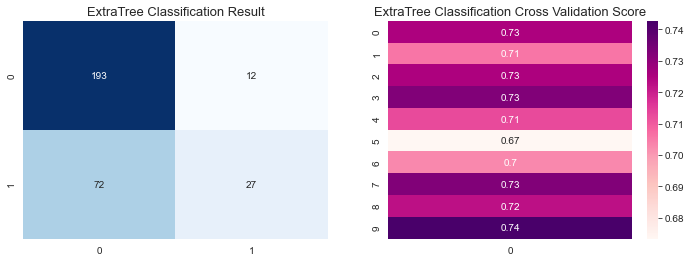

In [105]:
test_model(X_train, y_train, X_test, y_test)

### Conclusion

*summary*
<!--summary-->
In this project, I scraped YouTube search result data using web driver and BeautifulSoup. Five keyworkds -*mukbang, game, review, vlog, asmr* -are used to collect data. I attempted to use visible data on YouTube web page to predict rank of search results. EDA is conducted in order to explore relationship between each variable and it further gave me an insight to create my own YouTube search engine algorithm as an side project.

*model evaluation*
<!--model-->
Response column is encoded as binary variable (0:not listed in top3, 1:listed in top3), therefore a variety of classification models are used to predict the response column. Model used in this analysis are as follows: 'SVM', 'Logistic Regression', 'Decision Tree', 'KNearestNeighbor', 'GaussianNB', 'RandomForest','AdaBoost', 'ExtraTree', 'GradientBoost'.

<!--tuning-->
By adopting CV score and accuracy, three ensemble models are selected: RandomForest, ExtraTree and Gradient Boost. After tuning hyperparameters, the model performance are improved. ExtraTree model has shown the best performance amongst others therefore it used as the final model. The final mean accuracy is .72 ,increased from .68 before conducting hyperparameter tuning. 

*project limitation*
<!--limitation-->
This project has limitation as it does not have enough information to predict search result rank. Information such as user's watch history, logs, clicks, advertisement and preferences would be significant factors affect search rank. Due to lack of data diversity, this project necessarily has limitation to some extent. 

*Future work*
<!--Suggestion-->
With more data available, motel performance would be highly improved. Based on analysis conducted in this project, I have created a search engine algorithm as a side project, which can be viewed in (link!)